In [216]:
import time
import torch
from torch import Tensor
import utils as prologue

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# 1 Introduction

In [43]:
def nearest_classification(train_input, train_target, x):
    """
    A function that gets a training set and a test sample and returns the label of the training point
    the closest to the latter.

    param train_input: is a 2d float tensor of dimension n × d containing the training vectors
    param train_target: is a 1d long tensor of dimension n containing the training labels
    param x: is 1d float tensor of dimension d containing the test vector
    
    returns class of the train sample closest to x using the L^2 norm
    """
    return train_target[torch.argmin(torch.sum(torch.pow(train_input - x, 2), dim=1))]

# 2 Error estimation

In [246]:
def compute_nb_errors(train_input, train_target, test_input, test_target, mean = None, proj = None):
    """
    Function that subtracts mean (if it is not None) from the vectors of both train_input
    and test_input, apply the operator proj (if it is not None) to both.
    
    param train_input: is a 2d float tensor of dimension n × d containing the train vectors
    param train_target: is a 1d long tensor of dimension n containing the train labels
    param test_input: is a 2d float tensor of dimension m × d containing the test vectors
    param test_target: is a 1d long tensor of dimension m containing the test labels
    param mean: is either None or a 1d float tensor of dimension d
    param proj: is either None or a 2d float tensor of dimension c × d
    
    returns the number of classification errors using the 1-NN rule on the resulting data.
    """
    if mean is not None:
        train_input = train_input - mean
        test_input  = test_input  - mean

    if proj is not None:
        train_input = train_input @ proj.T 
        test_input  = test_input  @ proj.T
    
    classification_errors = 0
    
    for example in range(test_input.size()[0]):
        classification_errors += int(test_target[example] != nearest_classification(train_input, train_target, test_input[example, :]))
    
    return classification_errors

# 3 PCA

In [185]:
def pca(x):
    """
    Principal Component Analysis
    
    param x: is a 2d float tensor of dimension n × d
    
    returns a pair composed of the 1d mean vector of dimension d and
            the PCA basis, ranked in decreasing order of the eigen-values, as a 2d tensor d x d
    """
    eig_vals, eig_vecs = torch.eig(x.T @ x, eigenvectors=True)
    
    _, indices = torch.sort(eig_vals[:, 0], descending=True)
    
    return torch.mean(x, dim=0), eig_vecs[:, indices]

# 4 Check that all this makes sense

In [101]:
# Suggestion from https://stackoverflow.com/questions/60548000/getting-http-error-403-forbidden-error-when-download-mnist-dataset
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [244]:
train_input, train_target, test_input, test_target = prologue.load_data(cifar=True)

print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

* Using CIFAR


0it [00:00, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10/
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
train_input torch.Size([1000, 3072]) train_target torch.Size([1000])
test_input torch.Size([1000, 3072]) test_target torch.Size([1000])


In [245]:
compute_nb_errors(train_input, train_target, test_input[:100, :], test_target[:100])

71

In [247]:
pca_mean, pca_basis = pca(train_input)

In [252]:
compute_nb_errors(train_input, train_target, test_input, test_target, pca_mean, pca_basis[:100, :])

764

In [240]:
to_pca = (train_input @ pca_basis[:3, :].T).numpy()
classes = np.array([train_target.numpy()])

In [241]:
df = pd.DataFrame(np.concatenate((to_pca, classes.T), axis=1))

In [242]:
df.head()

,0,1,2,3
0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,4.0
3,0.0,0.0,0.0,1.0
4,0.0,14.0,184.0,9.0


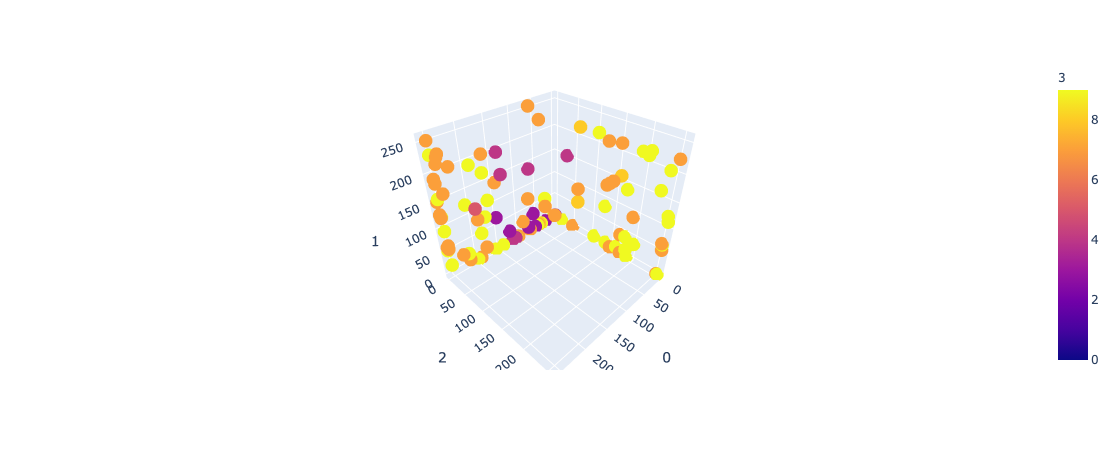

In [243]:
px.scatter_3d(df, x=0, y=2, z=1, color=3)